In [13]:
import pygame
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import sys
import os
sys.path.append('~/Desktop/Tufts-CS/CS138')
from track import build_track
# Constants
GRID_SIZE = 32
CELL_SIZE = 20
FPS = 60
GRID_WIDTH = GRID_SIZE * CELL_SIZE
GRID_HEIGHT = GRID_SIZE * CELL_SIZE
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
TRACK_COLOR = (120, 120, 120)
GRAVEL_COLOR = (255, 255, 255)
FIN_COLOR = (255, 0, 0)
START_COLOR = (0, 255, 0)
CAR_COLOR = (0, 0, 255)
GRAVEL = -1
TRACK = 0
START = 1
FINISH = 2
num_action = 9
# ##build the track
track = build_track()

In [3]:
!pip install pygame

     |████████████████████████████████| 12.8 MB 5.8 MB/s eta 0:00:01


In [23]:
class Environment:
    def __init__(self, track):
        self.track = track
        rows, cols = list(np.where(track == START))
        self.start_set = list(zip(rows, cols))
        rows, cols = list(np.where(track == GRAVEL))
        self.gravel_set = list(zip(rows, cols))
#         self.state = self.start_set[np.random.choice([i for i in range(len(start_set))])]

        self.num_action = 9

        self.screen = None
        self.clock = None

    ##Return a start position
    def reset(self):
        state = self.start_set[np.random.choice([i for i in range(len(self.start_set))])]
        return state, [0,0]

    def check_finish(self, state):
        rows, cols = np.where(self.track == FINISH)
        x, y = state
        if x in rows and y >= cols[0]:
            return True
        return False

    def check_crash(self, old_state, new_state):
        x_new, y_new = new_state
        x_old, y_old = old_state
        ##check if the new state is out of track
        if x_new < 0 or x_new >= GRID_SIZE or y_new < 0 or y_new >= GRID_SIZE or self.track[x_new][y_new] == GRAVEL:
            return True

        ##check if the projected path intersects the boundary
        for r in range(x_old, x_new + 1):
            if self.track[r, y_old] == GRAVEL:
                return True
        for c in range(y_old, y_new + 1):
            if self.track[x_old, c] == GRAVEL:
                return True

        return False

    def take_action(self, state, speed, action):
        ##speeds on both directions >= 0 and < 5
        ##speeds on both directions cannot be 0 at the same time
        ##speeds has 10% chance of not increase
        reward = -1
        new_x_speed, new_y_speed = 0, 0
        x_acc, y_acc = action

        threshold = np.random.rand()
        if threshold <= 0.1:
            ##speeds don't change
            new_x_speed, new_y_speed = speed[0], speed[1]
        else:
            new_x_speed = speed[0] + x_acc
            if new_x_speed < 0: new_x_speed = 0
            if new_x_speed > 4: new_x_speed = 4

            ## if the x speed is already 0, then y speed cannot be 0
            if new_x_speed == 0 and speed[1] + y_acc == 0:
                new_y_speed = speed[1] ##doesn't change
            else:
                new_y_speed = speed[1] + y_acc
                if new_y_speed < 0: new_y_speed = 0
                if new_y_speed > 4: new_y_speed = 4
#             if new_x_speed == new_y_speed == 0 and state in self.start_set:
#                 new_x_speed, new_y_speed = 0,1

        new_state = (state[0] - new_x_speed, state[1] + new_y_speed)
        new_speed = [new_x_speed, new_y_speed]

        terminated = False
        if self.check_finish(new_state):
            terminated = True
            rows, cols = np.where(self.track == FINISH)
            new_state = (new_state[0], cols[0])
            # new_speed = [0, 0]
        elif self.check_crash(state, new_state):
            new_state = self.start_set[np.random.choice([i for i in range(len(self.start_set))])]
            new_speed = [0, 0]


        return reward, terminated, new_state, new_speed


    def draw_grid(self, grid, state):
        for y in range(GRID_SIZE):
            for x in range(GRID_SIZE):
                if grid[x][y] == START:
                    color = START_COLOR
                    pygame.draw.rect(self.screen, START_COLOR, (y * CELL_SIZE, x * CELL_SIZE, CELL_SIZE, CELL_SIZE), 0)

                elif grid[x][y] == FINISH:
                    color = FIN_COLOR
                    pygame.draw.rect(self.screen, FIN_COLOR, (y * CELL_SIZE, x * CELL_SIZE, CELL_SIZE, CELL_SIZE), 0)

                if grid[x][y] == TRACK:
                    color = TRACK_COLOR
                elif grid[x][y] == GRAVEL:
                    color = GRAVEL_COLOR
                pygame.draw.rect(self.screen, color, (y * CELL_SIZE, x * CELL_SIZE, CELL_SIZE, CELL_SIZE), 1)

        ##Draw the car
        pygame.draw.rect(self.screen, CAR_COLOR, (state[1] * CELL_SIZE, state[0] * CELL_SIZE, CELL_SIZE, CELL_SIZE), 0)


    def display(self, state):
        if self.screen == None:
          # Initialize Pygame
          pygame.init()
          # Create a Pygame window
          self.screen = pygame.display.set_mode((GRID_WIDTH, GRID_HEIGHT))
          pygame.display.set_caption("Race Track")
          self.clock = pygame.time.Clock()

        self.screen.fill(WHITE)
        self.draw_grid(self.track, state)

        pygame.display.update()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.window = None
                pygame.quit()
                self.truncated = True
        self.clock.tick(FPS)
        running = True
#         while running:
#             for event in pygame.event.get():
#                 if event.type == pygame.QUIT:
#                     running = False

#             self.screen.fill(WHITE)  # Clear the screen
#             self.draw_grid(self.track, state)     # Draw the grid
#             pygame.display.flip()
#             self.clock.tick(FPS)
#         pygame.quit()



In [33]:
class Agent:
    def __init__(self, epsilon = 0.1, gamma = 0.9):
        self.epsilon = epsilon
        self.gamma = gamma
        self.speed = [0, 0]   ##[horizontal speed, vertical speed]

        self.actions = {
            0: [1, 1],
            1: [0, -1],
            2: [0, 1],
            3: [1, 0],
            4: [1, -1],
            5: [0, 0],
            6: [-1, 0],
            7: [-1, -1],
            8: [-1, 1]
        }

        self.state = [0, 0]
        self.num_actions = len(self.actions)
        self.Q = np.zeros((GRID_SIZE, GRID_SIZE, self.num_actions))   # Initialize action 
        self.Q -= 100
        self.N = np.zeros((GRID_SIZE, GRID_SIZE, self.num_actions))  # Visit count for each state-action pair
        self.C = np.zeros((GRID_SIZE, GRID_SIZE, self.num_actions))
        self.target_policy = np.argmax(self.Q, axis = -1)

    def reset(self, start_state):
        self.state = start_state
        self.speed = [0, 0]

    ##Q is the q value of a given state, should be an array of size 9
    def soft_policy(self, Q):
        epsilon = self.epsilon
        num_actions = self.num_actions
        policy = np.ones(num_actions) * epsilon / num_actions
        A_opt = np.argmax(Q)
        policy[A_opt] = 1 - epsilon + epsilon / num_actions
        # print(f"policy is: {policy}")
        return policy

    def mc_control(self, env, num_episodes, on_policy = True):
        for i,j in env.start_set:
            self.Q[i][j][5] = -1000
            self.Q[i][j][7] = -1000
            self.target_policy = np.argmax(self.Q, axis = -1)
        episode_len = []
        for episode in range(num_episodes):
            self.state, self.speed = env.reset()
            episode_states = []
            policy = None

            # Generate an episode using ε-soft policy
            while True:
                policy = self.soft_policy(self.Q[self.state])
                action = np.random.choice(np.arange(self.num_actions), p=policy)
                if self.state in env.start_set and action in [1,5,7]:
                    action = 2
                # print(action, self.actions[action])
                reward, terminated, new_state, new_speed = env.take_action(self.state, self.speed, self.actions[action])
#                 uncomment the following line to watch the training process
#                 env.display(self.state) 
                
                episode_states.append((self.state, action, reward))
                self.state = new_state
                self.speed = new_speed


                if terminated:
                    break
            episode_len.append(len(episode_states))
            G = 0.0
            if on_policy:
                ##on-policy MC control
                for t in reversed(range(len(episode_states))):
                    state, action, reward = episode_states[t]
                    i, j = state
                    G = self.gamma * G + reward

                    self.N[i][j][action] += 1
                    self.Q[i][j][action] += 1 / self.N[i][j][action] * (G - self.Q[i][j][action])
            
            else:
                W = 1.0
                for t in reversed(range(len(episode_states))):
                    state, action, reward = episode_states[t]
                    i, j = state
                    G = self.gamma * G + reward

                    self.C[i][j][action] += W
                    self.Q[i][j][action] += W / self.C[i][j][action] * (G - self.Q[i][j][action])
                    self.target_policy[i][j] = np.argmax(self.Q[i][j])
#                     print(self.target_policy[i][j], action)
                    if self.target_policy[i][j] != action:
                        break
                    W = W * 1 / policy[action]
                
        return episode_len
    

In [43]:
##train off-policy
race_track = Environment(track)
gammas = [0.6, 0.7, 0.8, 0.9]
epsilons = [0.1,0.15,0.2,0.25]
res1 = []
# for g in gammas:
#     agent1 = Agent(gamma = g)
#     episode_len1 = agent1.mc_control(race_track, 1000, on_policy=True)
#     res.append(episode_len1)
for e in epsilons:
    agent1 = Agent(epsilon = e)
    episode_len1 = agent1.mc_control(race_track, 1000, on_policy=False)
    res1.append(episode_len1)


In [39]:
##train on-policy
race_track = Environment(track)
gammas = [0.6, 0.7, 0.8, 0.9]
epsilons = [0.1,0.15,0.2,0.25]
res = []
# for g in gammas:
#     agent1 = Agent(gamma = g)
#     episode_len1 = agent1.mc_control(race_track, 1000, on_policy=True)
#     res.append(episode_len1)
for e in epsilons:
    agent1 = Agent(epsilon = e)
    episode_len1 = agent1.mc_control(race_track, 1000, on_policy=True)
    res.append(episode_len1)

In [68]:
race_track = Environment(track)
agent1 = Agent()
episode_len1 = agent1.mc_control(race_track, 100000, on_policy=True)

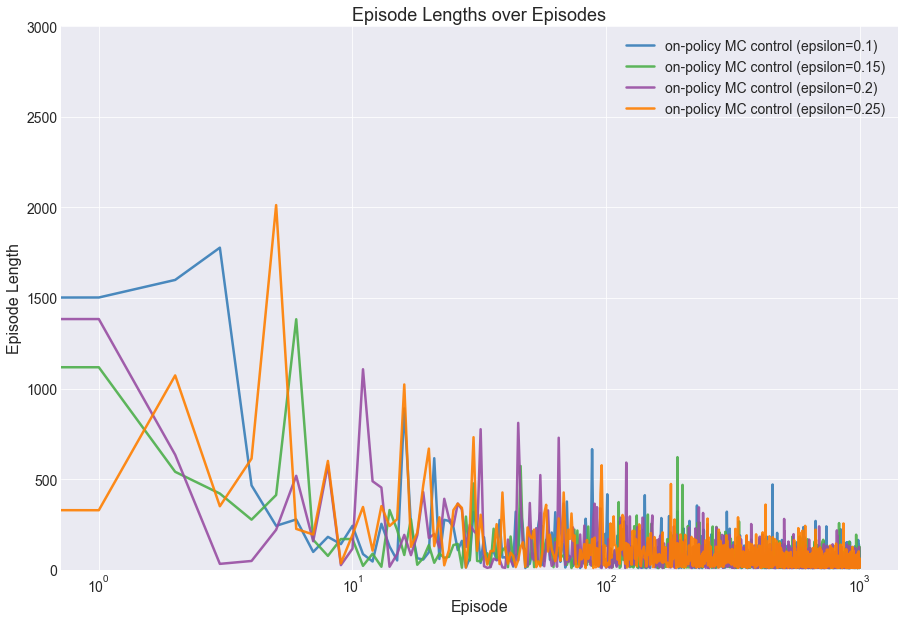

In [54]:
plt.figure(figsize = (15,10))
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
for i in range(len(gammas)):
    plt.semilogx(np.arange(1000), res[i], color=palette(i+1), linewidth=2.5, alpha=0.9, label=f'on-policy MC control (epsilon={epsilons[i]})')
# plt.semilogx(np.arange(100000), episode_len, color=palette(1), linewidth=1.5, alpha=0.9, label='off-policy MC control')
plt.ylim(0, 3000)
plt.xlabel('Episode', fontsize=16)
plt.ylabel('Episode Length', fontsize=16)
plt.title('Episode Lengths over Episodes', fontsize=18)
# x_ticks = [0, 10, 100, 1000, 10000, 100000]
# plt.xticks(x_ticks, map(x_ticks, str()))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig("op_t2.png")

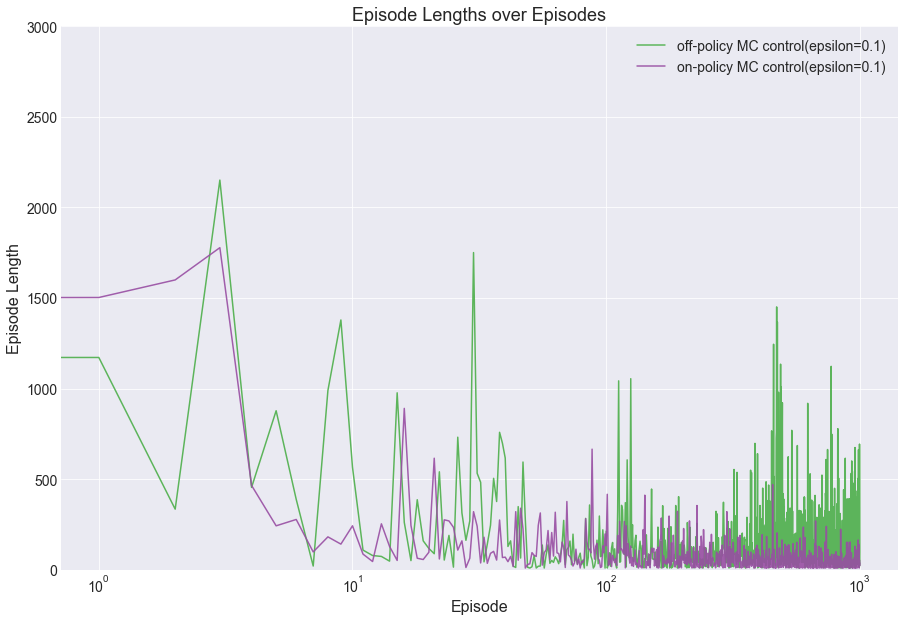

In [53]:
plt.figure(figsize = (15,10))
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
# for i in range(len(gammas)):
#     plt.semilogx(np.arange(1000), res1[i], color=palette(i+1), linewidth=2.5, alpha=0.9, label=f'off-policy MC control (epsilon={epsilons[i]})')
plt.semilogx(np.arange(1000), res1[0], color=palette(2), linewidth=1.5, alpha=0.9, label='off-policy MC control(epsilon=0.1)')
plt.semilogx(np.arange(1000), res[0], color=palette(3), linewidth=1.5, alpha=0.9, label='on-policy MC control(epsilon=0.1)')

plt.ylim(0, 3000)
plt.xlabel('Episode', fontsize=16)
plt.ylabel('Episode Length', fontsize=16)
plt.title('Episode Lengths over Episodes', fontsize=18)
# x_ticks = [0, 10, 100, 1000, 10000, 100000]
# plt.xticks(x_ticks, map(x_ticks, str()))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.savefig("op_t3.png")

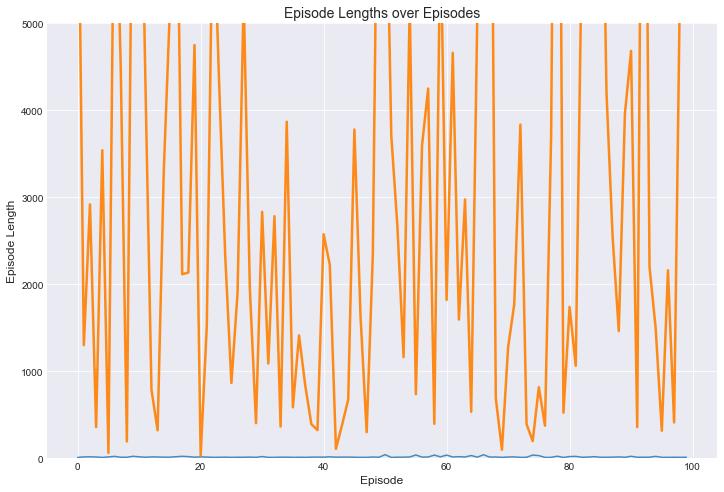

In [101]:
plt.figure(figsize = (12,8))
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
plt.plot(np.arange(100), episode_len1[-100:], color=palette(1), linewidth=1.5, alpha=0.9, label='off-policy MC control')
plt.plot(np.arange(100), episode_len[-100:], color=palette(4), linewidth=2.5, alpha=0.9, label='on-policy MC control')
plt.ylim(0, 5000)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Episode Length', fontsize=12)
plt.title('Episode Lengths over Episodes', fontsize=14)
plt.grid(True)
plt.show()

In [39]:
def draw_grid(screen,grid, path):
        for y in range(GRID_SIZE):
            for x in range(GRID_SIZE):
                if grid[x][y] == START:
                    color = START_COLOR
                    pygame.draw.rect(screen, START_COLOR, (y * CELL_SIZE, x * CELL_SIZE, CELL_SIZE, CELL_SIZE), 0)

                elif grid[x][y] == FINISH:
                    color = FIN_COLOR
                    pygame.draw.rect(screen, FIN_COLOR, (y * CELL_SIZE, x * CELL_SIZE, CELL_SIZE, CELL_SIZE), 0)

                if grid[x][y] == TRACK:
                    color = TRACK_COLOR
                elif grid[x][y] == GRAVEL:
                    color = GRAVEL_COLOR
                pygame.draw.rect(screen, color, (y * CELL_SIZE, x * CELL_SIZE, CELL_SIZE, CELL_SIZE), 1)
        
        #Draw the car
        for state in path:
            pygame.draw.rect(screen, CAR_COLOR, (state[1] * CELL_SIZE, state[0] * CELL_SIZE, CELL_SIZE, CELL_SIZE), 0)

def display(track,path, index):   
    # Initialize Pygame
    pygame.init()      
    # Create a Pygame window
    screen = pygame.display.set_mode((GRID_WIDTH, GRID_HEIGHT))
    pygame.display.set_caption("Race Track")       
    clock = pygame.time.Clock()
    screen.fill(WHITE)

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        screen.fill(WHITE)  # Clear the screen
        draw_grid(screen, track, path)     # Draw the grid
        pygame.display.flip()
        running = False
        screenshot_dir = "screenshots"  # Directory to save screenshots
        screenshot_name = f"screenshot{index}.png"  # Name of the screenshot file

        # Create the screenshots directory if it doesn't exist
        if not os.path.exists(screenshot_dir):
            os.makedirs(screenshot_dir)

        # Capture the current frame and save it as a screenshot
        pygame.image.save(screen, os.path.join(screenshot_dir, screenshot_name))
        clock.tick(FPS)
    pygame.quit()

In [187]:
def off_generate_tragectory(agent, env):
    agent.state, agent.speed = env.reset()
    episode_states = []
    total_reward = 0

    # Generate an episode using target policy
    while True:
        total_reward += -1
        episode_states.append(agent.state)
#         policy = agent.soft_policy(agent.Q[agent.state])
        action = agent.target_policy[agent.state]
        print(action, agent.actions[action])
        reward, terminated, new_state, new_speed = env.take_action(agent.state, agent.speed, agent.actions[action])
        print(new_state, new_speed)
        if new_state in env.start_set:
            episode_states = []
#             new_speed = [0,1]
        agent.state = new_state
        agent.speed = new_speed

        if terminated:
            episode_states.append(agent.state)
            break
    return episode_states, total_reward

In [188]:
for i in range(10):
    path, total_r = off_generate_tragectory(agent, race_track)
#     display(track, path, i)

1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]
1 [0, -1]
(31, 6) [0, 0]


KeyboardInterrupt: 

In [129]:
def on_generate_tragectory(agent, env):
    agent.state, agent.speed = env.reset()
    episode_states = []
    total_r = 0

    # Generate an episode using target policy
    while True:
        total_r += -1
        episode_states.append(agent.state)
        policy = agent.soft_policy(agent.Q[agent.state])
        action = np.random.choice(np.arange(agent.num_actions), p=policy)
        # print(action, self.actions[action])
        reward, terminated, new_state, new_speed = env.take_action(agent.state, agent.speed, agent.actions[action])
        if new_state in env.start_set:
            episode_states = []
        # env.display(self.state)                
        agent.state = new_state
        agent.speed = new_speed

        if terminated:
            episode_states.append(agent.state)
            break
    return episode_states, total_r



In [152]:
r_list1 = np.array(episode_len)
r_list1 = r_list1 * -1

In [141]:
for i in range(1000):
    path, total_r = generate_tragectory(agent, race_track)
    display(track, path, i)

# r_list = []
# for i in range(1000):
#     path, total_r = on_generate_tragectory(agent1, race_track)
#     r_list.append(total_r)


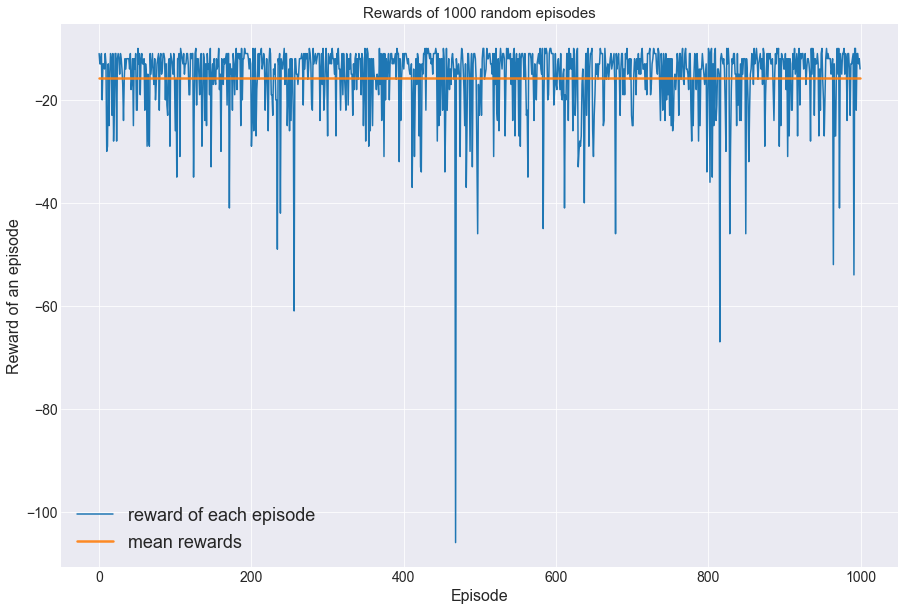

In [151]:
plt.figure(figsize = (15,10))
plt.style.use('seaborn-darkgrid')
plt.plot(np.arange(1000), r_list, label = "reward of each episode")
plt.plot(np.arange(1000), [np.mean(r_list)] * 1000, linewidth=2.5, alpha=0.9, label = "mean rewards")
plt.xlabel('Episode', fontsize=16)
plt.ylabel('Reward of an episode', fontsize=16)
plt.title('Rewards of 1000 random episodes', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize = 18)
plt.grid(True)
plt.savefig("screenshots/op_r.png")


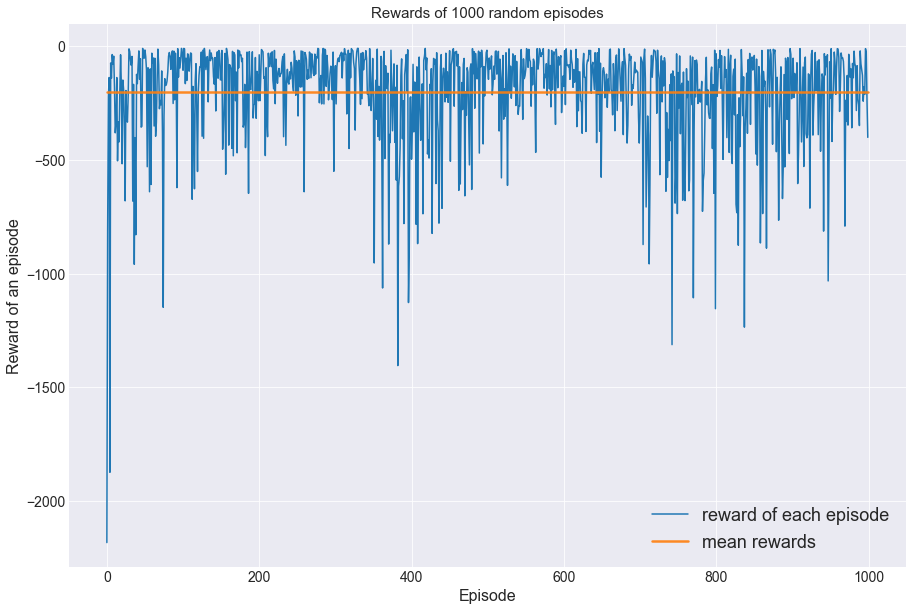

In [153]:
plt.figure(figsize = (15,10))
plt.style.use('seaborn-darkgrid')
plt.plot(np.arange(1000), r_list1, label = "reward of each episode")
plt.plot(np.arange(1000), [np.mean(r_list1)] * 1000, linewidth=2.5, alpha=0.9, label = "mean rewards")
plt.xlabel('Episode', fontsize=16)
plt.ylabel('Reward of an episode', fontsize=16)
plt.title('Rewards of 1000 random episodes', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend(fontsize = 18)
plt.savefig("screenshots/op_r1.png")


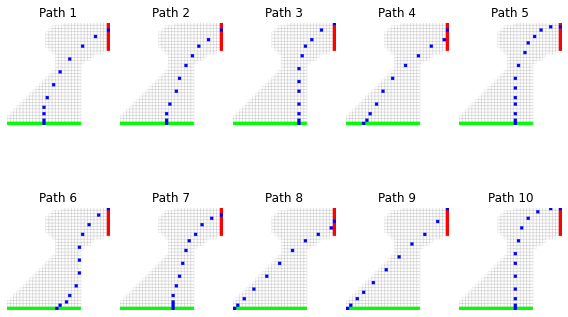

In [61]:
# Create a grid of subplots
num_rows = 2  # Number of rows in the grid
num_cols = 5  # Number of columns in the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 8))

# Populate the subplots with images
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j  # Calculate the index for accessing image_paths
        # Open the image using PIL
        img = Image.open(f'screenshots/screenshot{index}.png')

        # Display the image in the current subplot
        axes[i, j].imshow(img)

        # Set a title for the subplot (optional)
        axes[i, j].set_title(f'Path {index + 1}')

        # Turn off axis labels
        axes[i, j].axis('off')

# Adjust spacing between subplots
plt.tight_layout()
plt.subplots_adjust(hspace= -0.5)

# Show the plot
# plt.show()
plt.savefig('screenshots/fig1.png')
